In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import adabmDCA

from adabmDCA.utils import get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler

import sys
sys.path.append('..')
from selex_dca import *

import pickle
import glob
from math import ceil, sqrt, floor
import random

/Users/scrotti/Aptamer2025py/experiments/../selex_dca.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


File names for data

In [37]:
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
round_ids = ["ARN", "R01", "R02N"]
ns = range(len(experiment_ids))

In [6]:
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


## Extract sequences and compute 1st and 2nd moment statistics, write to files

In [7]:
sequences_all = [[sequences_from_file(experiment_id, round_id, device) 
                  for round_id in round_ids] for experiment_id in experiment_id_all];

In [8]:
pseudocounts = np.linspace(0, 1, 21)
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']

In [18]:
for n in range(len(sequences_all)):   
    experiment_id = experiment_ids[n]
    sequences_oh_all = [one_hot(seq, num_classes=4).to(dtype) for seq in sequences_all[n]]
    for pseudocount in pseudocounts:
        freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(
            *[frequences_from_sequences_oh(seq, pseudo_count=pseudocount, dtype=dtype) for seq in sequences_oh_all[n]])
        fi = torch.stack(freq_single_tuple)  # n_rounds, L, q
        fij = torch.stack(freq_pair_tuple)      # n_rounds, L, q, L, q
        total_reads = torch.tensor(total_reads_tuple)
    
        pc_str = format(pseudocount, '.2f')
        
        filename = experiment_id + "freq_pseudocount" + pc_str + ".pkl"
        filepath = "saved/freq_pseudocount/" + filename
        
        data = [fi, fij, total_reads]
        
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)

In [11]:
wts_sites = []

for n in range(len(sequences_all)):   
    experiment_id = experiment_ids[n]
    freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(
        *[frequences_from_sequences(seq, pseudo_count=0, dtype=dtype) for seq in sequences_all[n]])
    wt = guess_wildtype_from_site_counts(freq_single_tuple[0])
    print(experiment_id)
    wts_sites.append(wt)

Dop8V030
Dop8V930
Dop8V2430


In [17]:
filepath = 'saved/wildtypes_sites.pkl'
with open(filepath, 'wb') as f:
    pickle.dump(wts_sites, f)

# TODO: the same as below but at same pseudocount

In [136]:
ls = np.linspace(0, 1, 21)
ls_s = [format(x, '.2f') for x in ls]
' '.join(ls_s)

'0.00 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70 0.75 0.80 0.85 0.90 0.95 1.00'

## Read parameters of the 3 trained models

In [39]:
filepath = next(glob.iglob('./saved/pseudocount/*.pkl'))

In [40]:
def read_freq(experiment_idx):
    data = []
    for filepath in glob.iglob('./saved/pseudocount/*.pkl'):
        if filepath[20:].startswith(experiment_ids[experiment_idx]):
            with open(filepath, 'rb') as f:
                data.append(pickle.load(f))
    return data

In [47]:
_, _, params, pseudocount_, pearson_final = zip(*[zip(*read_freq(n)) for n in ns])

## Read parameters of trained models (only 1st dataset)

In [149]:
data = []

for filepath in glob.iglob('./saved/pseudocount/*.pkl'):
    with open(filepath, 'rb') as f:
        data.append(pickle.load(f))

print(f"Loaded {len(data)} files.")

experiment_id_all, round_ids_all, params_all, pseudocount_all, pearson_final_all = zip(*data)

pseudocount_all = np.array(pseudocount_all)
pearson_final_all = np.array(pearson_final_all)
assert((pearson_final_all > 0.9).all())

pc_idx = range(len(pseudocount_all))

Loaded 20 files.


In [16]:
ts = range(len(round_ids))

sequences_unique, inverse_indices, counts = zip(*[
    torch.unique(seq_t, dim=0, return_inverse=True, return_counts=True)
    for seq_t in sequences])
sequences_unique_oh = [one_hot(s) for s in sequences_unique]

In [17]:
params_t_all = [[get_params_at_round(params_all[a], t) for t in ts] for a in pc_idx]

In [18]:
logNst_all = [[-adabmDCA.statmech.compute_energy(sequences_unique_oh[t], params_t_all[a][t])
               for t in ts] for a in pc_idx]

In [19]:
logNst_thresh = -200

X, Y = zip(*[zip(*[vectors_for_scatterplot_single_t_unique(logNst_all[n][t], counts[t], logNst_thresh,
                                                  inverse_indices[t])
                  for t in ts]) for n in pc_idx])

In [20]:
pearson_logNst_all = [[torch.corrcoef(torch.stack((X[n][t], Y[n][t])))[0,1] for t in ts] for n in pc_idx]

In [50]:
pseudocount_all[pseudocount_all.argsort()]

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [53]:
pc_idx

range(0, 20)

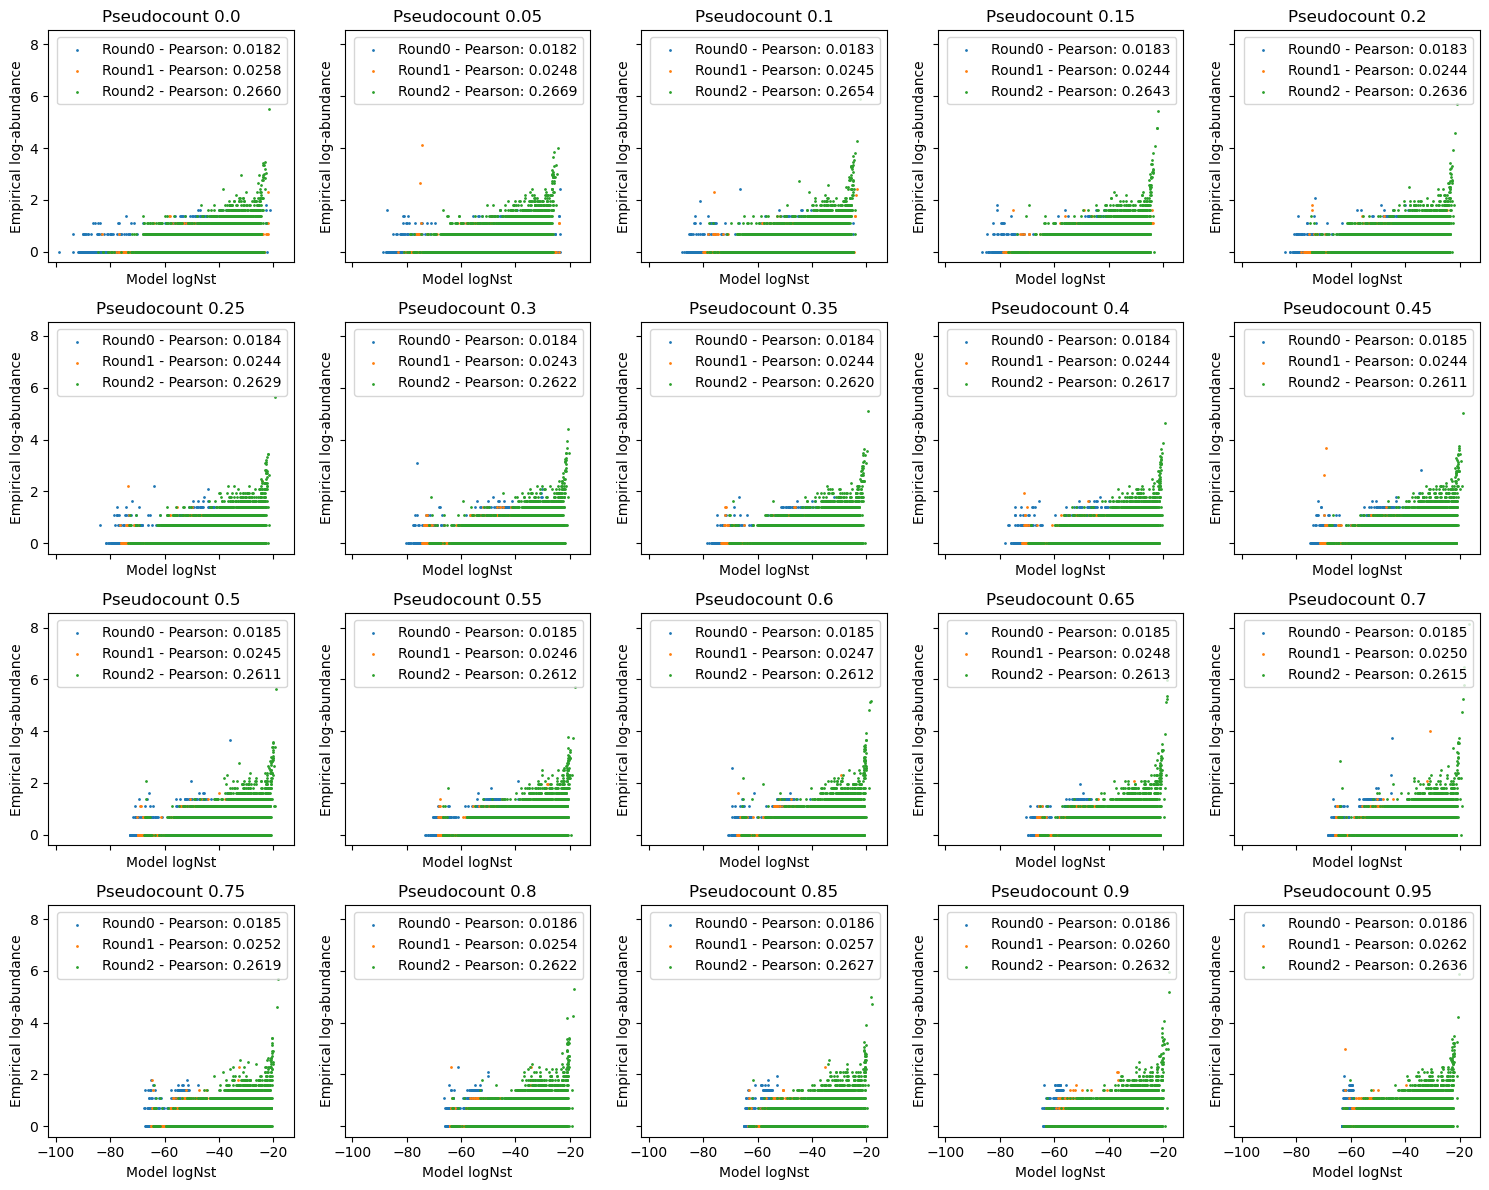

In [61]:
N = 10**4
l = ceil(sqrt(len(pseudocount_all)))
pl, axes = plt.subplots(l-1, l, figsize=(3*l,3*(l-1)), sharex=True, sharey=True)

for i in pc_idx:
    row    = floor(i / l)
    column = i % l
    ax = axes[row, column]
    n = pseudocount_all.argsort()[i]
    for t in ts:
        x = X[n][t]; y = Y[n][t]
        pearson = torch.corrcoef(torch.stack((x, y)))[0,1]
        idx = random.sample(range(len(x)),min(N, len(x)))
        ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson:.{4}f}", s=1)
        ax.set_xlabel("Model logNst")
        ax.set_ylabel("Empirical log-abundance")
        ax.set_title(f"Pseudocount {pseudocount_all[n]}")
    ax.legend()
plt.tight_layout()

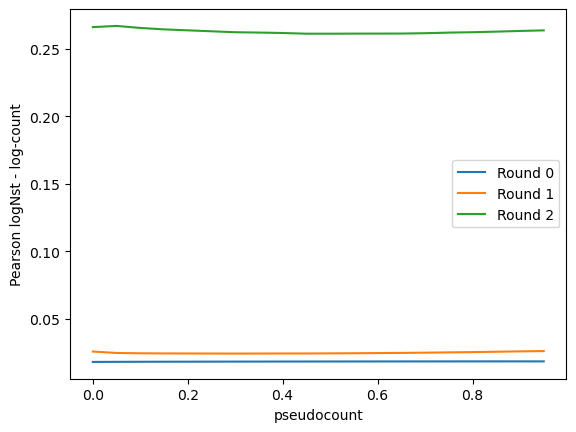

In [46]:
fig, ax = plt.subplots()
idx = pseudocount_all.argsort()
for t in ts:
    y = [pearson_logNst_all[n][t] for n in idx]
    ax.plot(pseudocount_all[idx], y, label=f"Round {t}")
    ax.set_xlabel('pseudocount')
    ax.set_ylabel('Pearson logNst - log-count')
ax.legend()

## Predict on the other datasets

In [62]:
sequences_others = [[sequences_from_file(experiment_id, round_id, device) 
                  for round_id in round_ids] for experiment_id in ["Dop8V930", "Dop8V2430"]]

In [78]:
data = []

for filepath in glob.iglob('./saved/*.pkl'):
    with open(filepath, 'rb') as f:
        data.append(pickle.load(f))

print(f"Loaded {len(data)} files.")

data = [data[i] for i in [2,0]]

Loaded 3 files.


In [82]:
_, _, params_others, _, _, _, _, _ = zip(*data)

In [ ]:
sequences_unique_others, counts_others = zip(*[zip(*[torch.unique(seq_t, dim=0, return_counts=True) for seq_t in sequences_others[n]]) for n in range(len(sequences_others))]) 

In [129]:
sequences_unique_oh_others = [[one_hot(s) for s in sequences_unique] for sequences_unique in sequences_unique_others]

In [155]:
experiment_id_others = ["Dop8V930", "Dop8V2430"]

In [137]:
logNst_x = [[[-adabmDCA.statmech.compute_energy(sequences_unique_oh_others[n][t], params_t_all[a][t]) for t in ts] for n in range(len(sequences_others))] for a in pc_idx]
logNst_y = [[[-adabmDCA.statmech.compute_energy(sequences_unique_oh_others[n][t], get_params_at_round(params_others[n], t)) for t in ts] for n in range(len(sequences_others))] for a in pc_idx]

In [247]:
_, wt = guess_wildtype_from_sequence_counts(sequences_unique[0], counts[0])
wt_oh = one_hot(wt[None,:], 4)

In [312]:
logNst_wildtype_x = [[[-adabmDCA.statmech.compute_energy(wt_oh, params_t_all[a][t]) for t in ts] for n in range(len(sequences_others))] for a in pc_idx]
logNst_wildtype_y = [[[-adabmDCA.statmech.compute_energy(wt_oh, get_params_at_round(params_others[n], t)) for t in ts] for n in range(len(sequences_others))] for a in pc_idx]

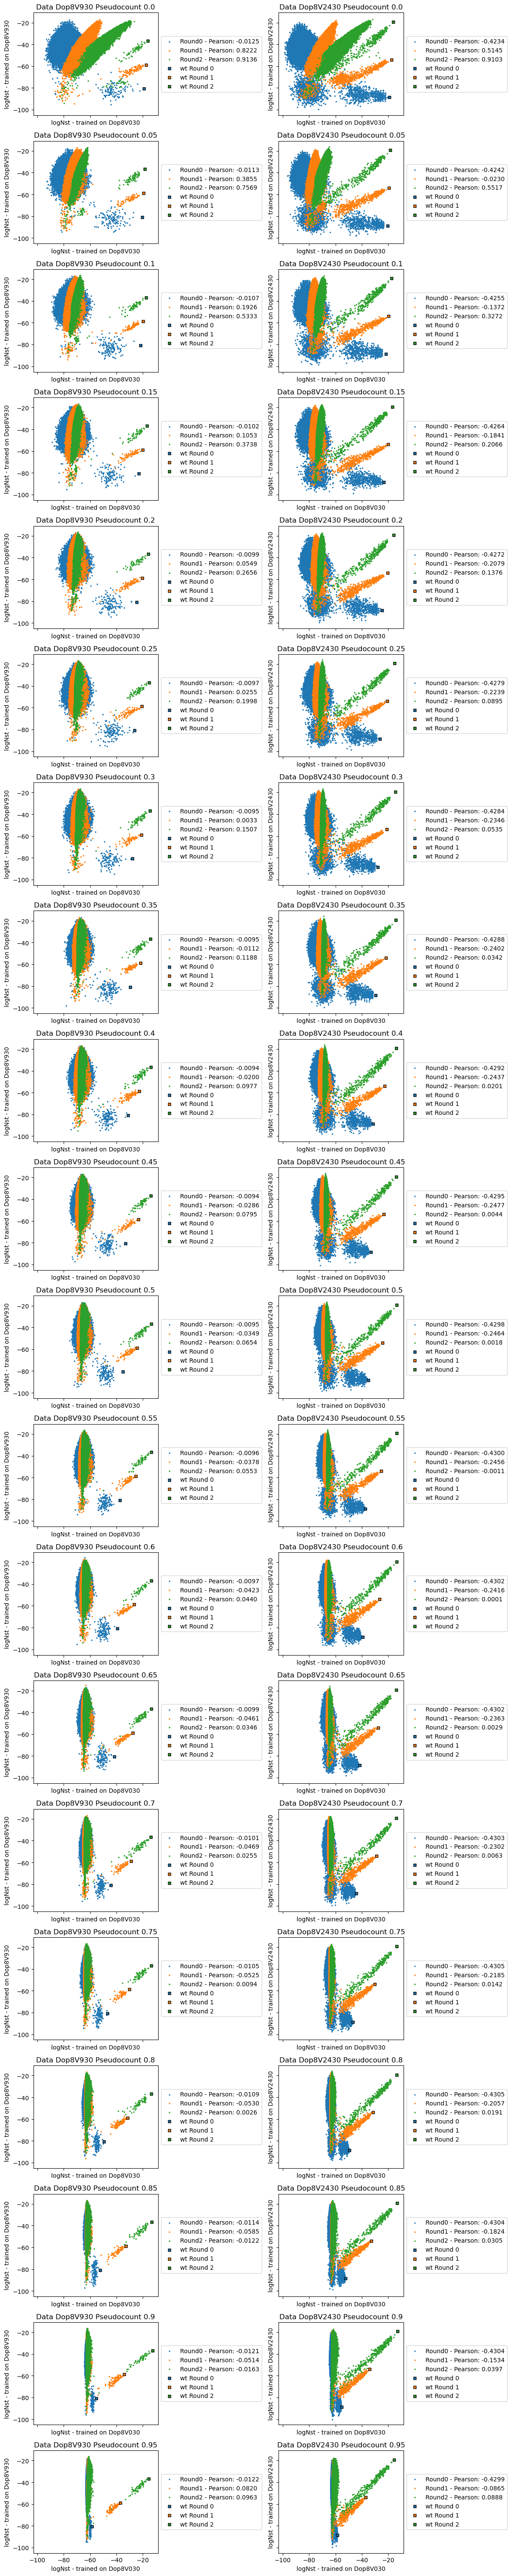

In [325]:
N = 10**5

fig, axes = plt.subplots(len(pc_idx), 2, figsize=(12,3*len(pc_idx)), sharex=True, sharey=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in pc_idx:
    a = pseudocount_all.argsort()[b]
    for i in range(len(sequences_others)):
        ax = axes[b,i]
        for t in ts:
            x = logNst_x[a][i][t]
            y = logNst_y[a][i][t]
            pearson = torch.corrcoef(torch.stack((x,y)))[0,1]            
            idx = random.sample(range(len(x)),min(N, len(x)))
            ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson:.{4}f}", s=2, color=colors[t])
            ax.set_xlabel(f"logNst - trained on Dop8V030")
            ax.set_ylabel(f"logNst - trained on {experiment_id_others[i]}")
            ax.set_title(f"Data {experiment_id_others[i]} Pseudocount {pseudocount_all[a]}")
        for t in ts:
            ax.scatter(logNst_wildtype_x[a][i][t], logNst_wildtype_y[a][i][t], marker='s', label=f"wt Round {t}", s=20, 
                       color=colors[t], edgecolor='black')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

In [318]:
logps_x = [[[-adabmDCA.statmech.compute_energy(sequences_unique_oh_others[n][t], get_params_ps(params_all[a])) for t in ts] for n in range(len(sequences_others))] for a in pc_idx]
logps_y = [[[-adabmDCA.statmech.compute_energy(sequences_unique_oh_others[n][t], get_params_ps(params_others[n])) for t in ts] for n in range(len(sequences_others))] for a in pc_idx]

In [319]:
logps_wildtype_x = [[[-adabmDCA.statmech.compute_energy(wt_oh, get_params_ps(params_all[a])) for t in ts] for n in range(len(sequences_others))] for a in pc_idx]
logps_wildtype_y = [[[-adabmDCA.statmech.compute_energy(wt_oh, get_params_ps(params_others[n])) for t in ts] for n in range(len(sequences_others))] for a in pc_idx]

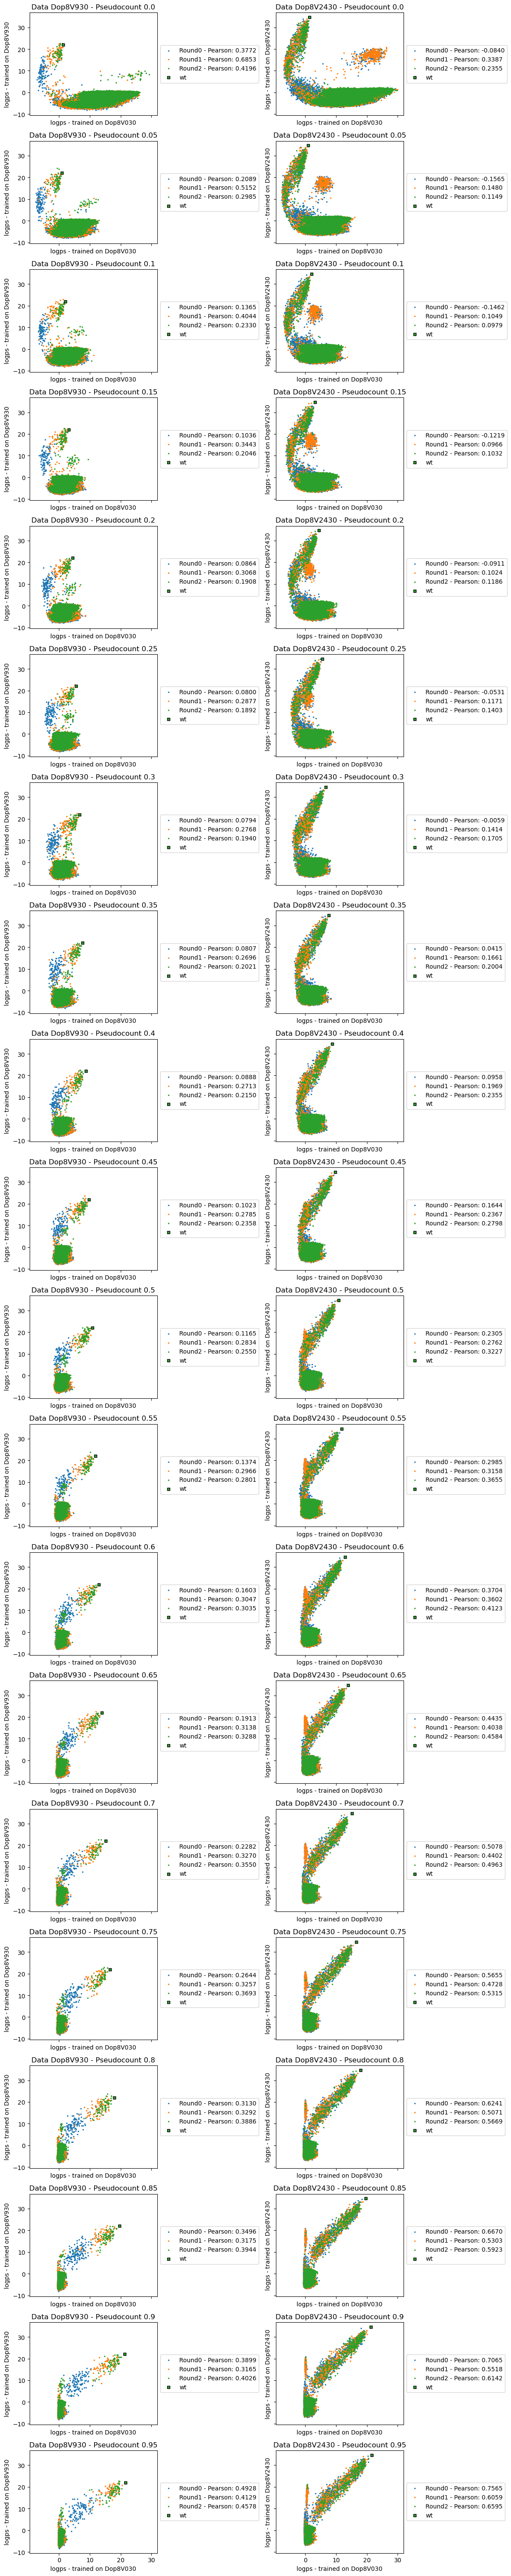

In [324]:
N = 10**5

fig, axes = plt.subplots(len(pc_idx), 2, figsize=(12,3*len(pc_idx)), sharex=True, sharey=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in pc_idx:
    a = pseudocount_all.argsort()[b]
    for i in range(len(sequences_others)):
        ax = axes[b,i]
        for t in ts:
            x = logps_x[a][i][t]
            y = logps_y[a][i][t]
            pearson = torch.corrcoef(torch.stack((x,y)))[0,1]            
            idx = random.sample(range(len(x)),min(N, len(x)))
            ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson:.{4}f}", s=2)
            ax.set_xlabel(f"logps - trained on Dop8V030")
            ax.set_ylabel(f"logps - trained on {experiment_id_others[i]}")
            ax.set_title(f"Data {experiment_id_others[i]} - Pseudocount {pseudocount_all[a]}")
        ax.scatter(logps_wildtype_x[a][i][0], logps_wildtype_y[a][i][0], marker='s', label="wt",
           s=20, color=colors[t], edgecolors='black')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

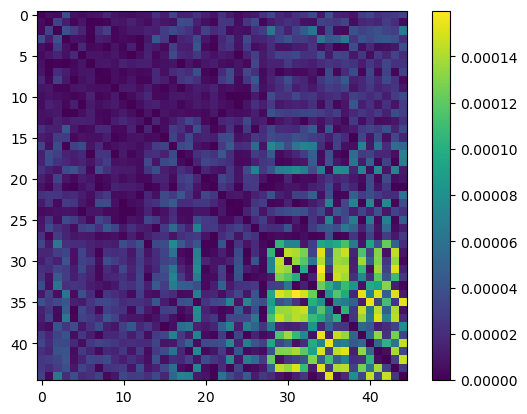

In [241]:
import numpy as np

a = pseudocount_all.argsort()[1]

h = params_all[a]["bias_ps"].reshape(-1)
J = params_all[a]["couplings_ps"].reshape(45*4, 45*4)

# eigs = np.linalg.eig(J)
# lambdaJ = eigs.eigenvalues
# vJ = eigs.eigenvectors
# # plt.plot(abs(lambdaJ))
# vJ[:,0].reshape(45, 4)
F = torch.sqrt(params_all[a]["couplings_ps"].sum(dim=(1,3))**2)
plt.imshow(F)
plt.colorbar()

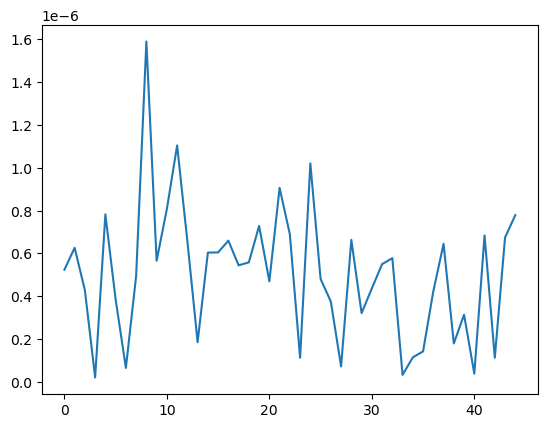

In [240]:
plt.plot(torch.sqrt(params_all[a]["bias_ps"].sum(dim=1)**2))

In [175]:
a = pseudocount_all.argsort()[-1]

n = 1
X = logps_x[a][n]
Y = logps_y[a][n]

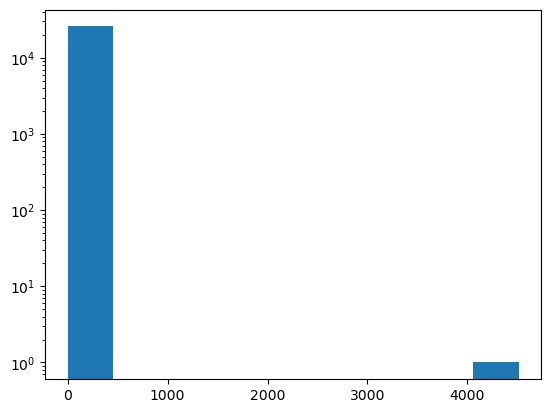

In [198]:
t = 2

id = (X[t] > 15) * (Y[t] > 15)
plt.hist(counts_others[n][t][id])
plt.yscale('log')

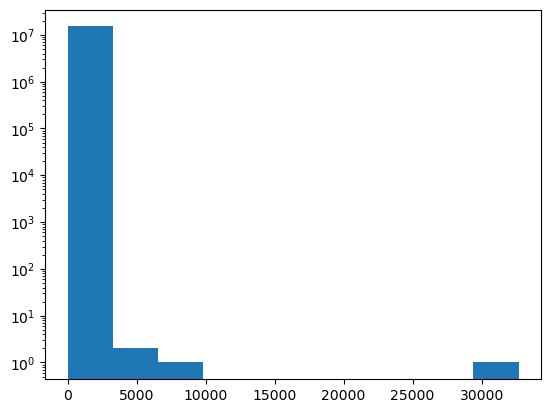

In [199]:
plt.hist(counts_others[n][t])
plt.yscale('log')